In [ ]:
!wget https://www.dropbox.com/s/w3zlhing4dkgeyb/train.zip?e=1&dl=0

# unzip the data

!unzip train.zip?e=1&dl=0

--2024-05-08 18:45:05--  https://www.dropbox.com/s/w3zlhing4dkgeyb/train.zip?e=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.18, 2620:100:6028:18::a27d:4712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/w3zlhing4dkgeyb/train.zip [following]
--2024-05-08 18:45:05--  https://www.dropbox.com/s/raw/w3zlhing4dkgeyb/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdbd8977db929e5a36d1f5efd66.dl.dropboxusercontent.com/cd/0/inline/CSiCLPS95Qz3-T9ZKHaK-I0nnsqRGK6SK3Ml5dkLYVa_GNlFyuGKXZRsFGTE9DA-KVC1BRyHp1bU7iHjFjG7u6giJAQiUlP1SZ_vju-5UO2bgEPx8acDE_TS8N7GeGWiLHioooZbdz8j9RvSz2C_a9Y3/file# [following]
--2024-05-08 18:45:06--  https://ucdbd8977db929e5a36d1f5efd66.dl.dropboxusercontent.com/cd/0/inline/CSiCLPS95Qz3-T9ZKHaK-I0nnsqRGK6SK3Ml5dkLYVa_GNlFyuGKXZRsFGTE9DA-KVC1BRyHp1bU7iHjFjG7u6giJAQiUlP1SZ_vju-5

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.applications.mobilenet import MobileNet, preprocess_input #pretrained model
from keras.models import Model #functional API
from keras.layers import Flatten, Dense

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


Building the model

In [ ]:
base_model = MobileNet( input_shape=(224,224,3), include_top= False )

for layer in base_model.layers: # to prevent retrain
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=7 , activation='softmax' )(x)

# creating our model.
model = Model(base_model.input, x)

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [ ]:
model.compile(optimizer='adam', loss= "categorical_crossentropy" , metrics=['accuracy']  )

Preparing the data

In [ ]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2,
     shear_range = 0.2,
     horizontal_flip=True,
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/train",
                                               target_size=(224,224),
                                               batch_size=32,
                                  )


train_data.class_indices

Found 350 images belonging to 7 classes.


{'Angry': 0,
 'Disguist': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1/255 )

val_data = val_datagen.flow_from_directory(directory= "/content/train",
                                           target_size=(224,224),
                                           batch_size=32,
                                  )

Found 350 images belonging to 7 classes.


visualizing the data that is fed to train data gen

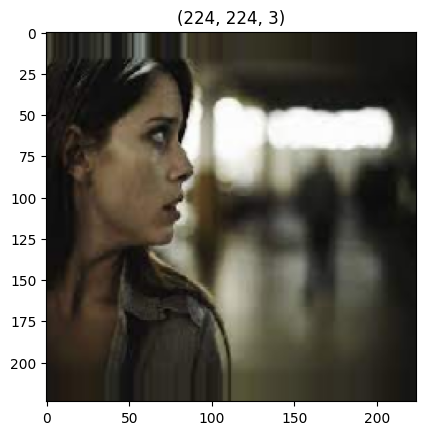

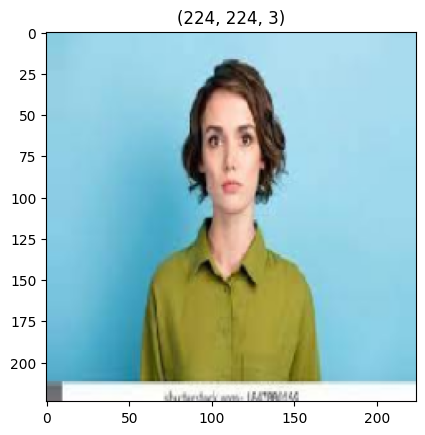

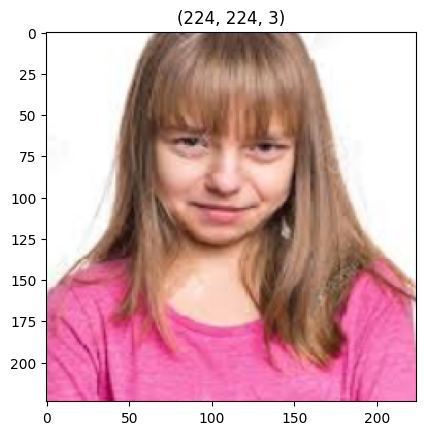

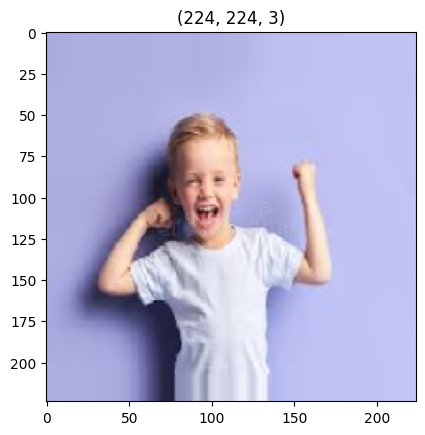

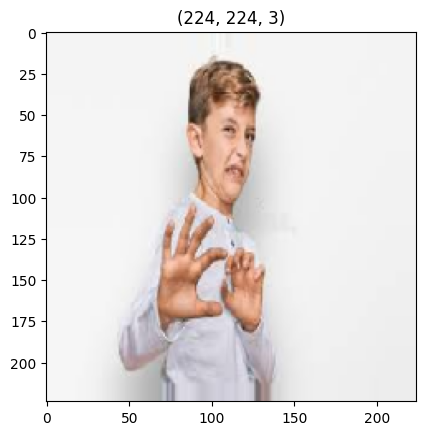

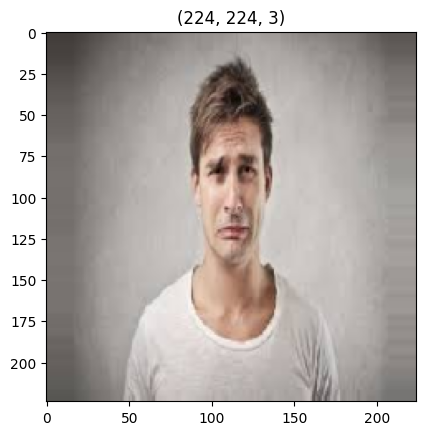

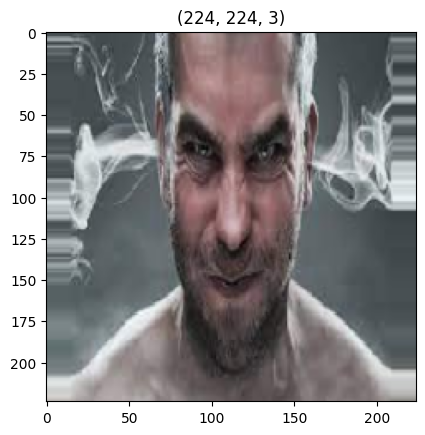

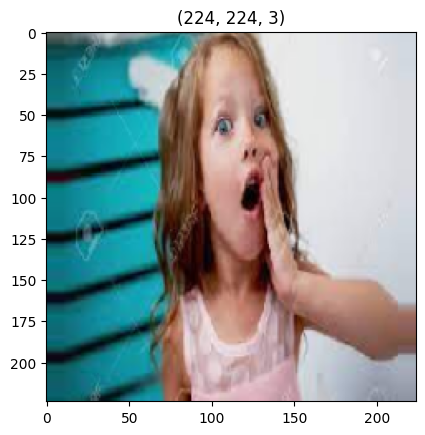

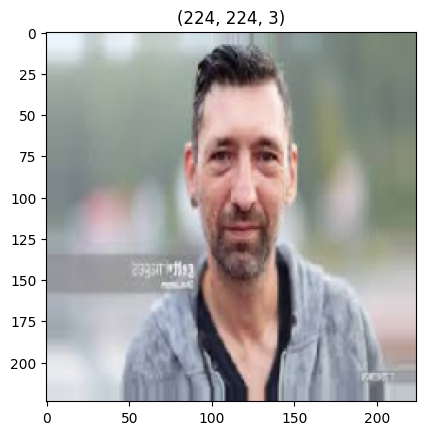

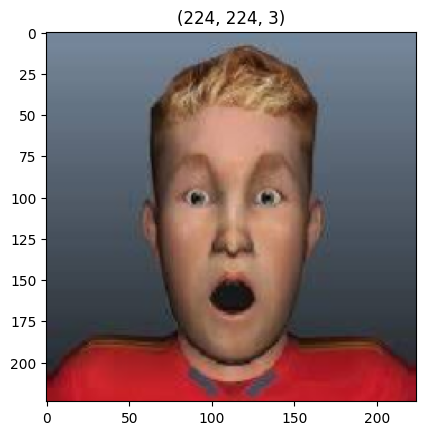

In [ ]:
# to visualize the images in the traing data denerator

t_img , label = train_data.next()

#-----------------------------------------------------------------------------
# function when called will prot the images
def plotImages(img_arr, label):
  """
  input  :- images array
  output :- plots the images
  """
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()

    count += 1
    if count == 10:
      break

#-----------------------------------------------------------------------------
# function call to plot the images
plotImages(t_img, label)

having early stopping and model check point

In [ ]:
## having early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list
call_back = [es, mc]

In [ ]:
hist = model.fit_generator(train_data,
                           steps_per_epoch= 10,
                           epochs= 30,
                           validation_data= val_data,
                           validation_steps= 8,
                           callbacks=[es,mc])

<ipython-input-10-7dbb6b2d1ed1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_data,


Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 7.2727 - accuracy: 0.2438
Epoch 1: val_accuracy improved from -inf to 0.50391, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 38s 3s/step - loss: 7.2727 - accuracy: 0.2438 - val_loss: 3.7292 - val_accuracy: 0.5039
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 3.1049 - accuracy: 0.6069
Epoch 2: val_accuracy improved from 0.50391 to 0.71875, saving model to best_model.h5
10/10 [==============================] - 41s 4s/step - loss: 3.1049 - accuracy: 0.6069 - val_loss: 1.6751 - val_accuracy: 0.7188
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 1.5338 - accuracy: 0.7516
Epoch 3: val_accuracy improved from 0.71875 to 0.87500, saving model to best_model.h5
10/10 [==============================] - 39s 4s/step - loss: 1.5338 - accuracy: 0.7516 - val_loss: 0.6772 - val_accuracy: 0.8750
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 0.8553
Epoch 4: val_accuracy did not improve from 0.87500
10/10 [==============================] - 38s 4s/step - loss: 0.7437 - accuracy: 0.8553 - val_loss: 0.6517 - 

In [ ]:
# Loading the best fit model
from keras.models import load_model
model = load_model("/content/best_model.h5")


In [ ]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

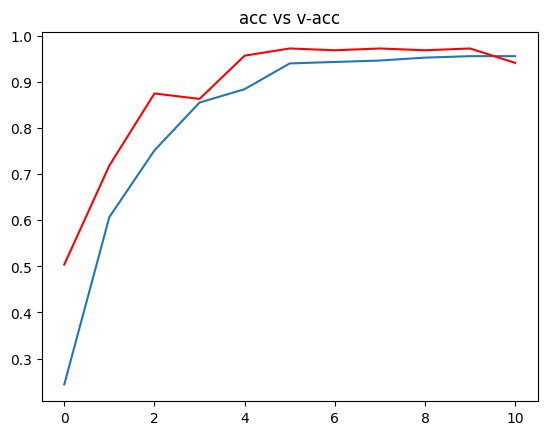

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

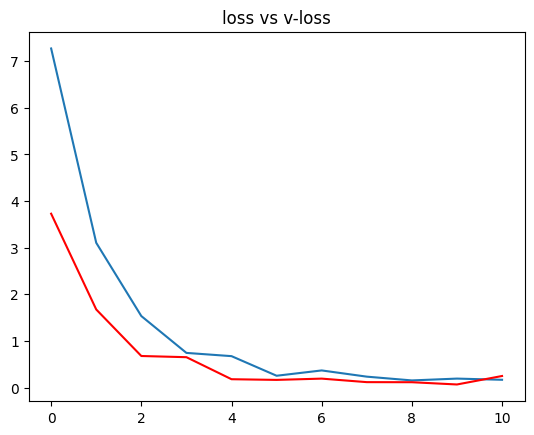

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [ ]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))